In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.base_models.SysuModel import SysuModel
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric,
    dice_loss
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math

strawberry


In [2]:
rand_generator = torch.manual_seed(1307)
seed=1307

In [3]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

In [4]:
def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
            
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

def none_transform():
    transforms = [
        LabelSelect(label_id=1),
        lambda x, y: (x, y.squeeze().type(torch.long))
    ]
    return PairedCompose(transforms)

def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

In [5]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [6]:
ckpt_dir = None
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]]
# domains = [ wmh_dir + d for d in ['Singapore', 'GE3T', 'Utrecht']]

train_proportion = 0.7
test_proportion = 0.1
validation_proportion = 0.2
seed = 3407

In [7]:
# ### dataset of combined datasets function
# from torch.utils.data import Dataset


# class MultiDataset(Dataset):
#     def __init__(self, datasets):
#         self.datasets = datasets
#         self.num = len(datasets)
#         size = 0
#         for d in datasets:
#             size += len(d)
        
#         self.size = size
#         idx_to_dataset_index = []
#         dataset_starting_index = []
        
#         ds_count = 0
#         starting_index = 0
#         for d in datasets:
#             d_size = len(d)
#             idx_to_dataset_index.append(torch.ones(d_size) * ds_count)
#             dataset_starting_index.append(starting_index)
            
#             ds_count += 1
#             starting_index += d_size
            
#         self.idx_to_dataset = torch.cat(idx_to_dataset_index, dim=0).type(torch.int32)
#         self.dataset_starting_index = dataset_starting_index
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         # find out which dataset to use
#         dataset_idx = self.idx_to_dataset[idx]
#         # get that dataset
#         dataset = self.datasets[dataset_idx]
#         # find out where the element is in that dataset
#         item_idx = idx - self.dataset_starting_index[dataset_idx]
        
#         return dataset[item_idx]


In [8]:
# ### subset view dataset
# class SubsetViewDataset(Dataset):
#     def __init__(self, base_dataset, index_subset):
#         """
#         base_dataset: the original dataset that we take a subset of
#         index_subset: the list of indexes selected from the base dataset (e.g [0,1,4] means only take elements 0, 1 and 4 from the base
#         dataset
#         """
        
#         self.size = len(index_subset)
#         self.base_dataset = base_dataset
#         self.indexes = index_subset
    
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         item_idx = self.indexes[idx]
#         return self.base_dataset[item_idx]

In [9]:
# ### train, val, test split function
# def train_test_split_indexes(dataset, seed, split_sizes=None, split_proportions=None):
#     if split_sizes == None: # generate split sizes from the proportions given
#         assert torch.sum(torch.Tensor(split_proportions)).item() == 1
        
#         l = len(dataset)
#         split_sizes = [int(l * p) for p in split_proportions[:-1]]
#         leftover = l - torch.sum(torch.Tensor(split_sizes)).item()
#         split_sizes.append(int(leftover))
    
#     assert torch.sum(torch.Tensor(split_sizes)).item() == len(dataset)
#     """
#     turns a single dataset into multiple splits of randomly selected items based on the split size list.
#     """
#     shuffled_indexes = torch.randperm(len(dataset), generator=torch.Generator().manual_seed(seed))
    
#     # generate the indexes each new dataset split can see in the original dataset
#     per_split_indexes = []
#     curr_pos = 0
#     for s in split_sizes:
#         # print(s)
#         per_split_indexes.append(shuffled_indexes[curr_pos: curr_pos + s])
#         curr_pos += s
        
#     # create the new datasets
#     new_datasets = [SubsetViewDataset(dataset, indexes) for indexes in per_split_indexes]
    
#     return new_datasets
    

In [10]:
### 3d to 2d dataset
class MRISegDataset2DFrom3D(Dataset):
    def __init__(self, dataset3D, transforms=None):
        # calculate total number of slices (note need to iterate through every item
        # because each image may have a different number of slices
        size = 0
        for data in dataset3D:
            x = data[0]
            size += x.shape[1]
            
        self.size = size
        self.dataset3D = dataset3D
        self.transforms = transforms
        
        idx_to_scan_index = []
        scan_starting_index = []
        
        scan_count = 0
        starting_index = 0
        for (ind, _) in dataset3D:
            d_size = ind.shape[1] # slices are the second dim of 3D scan
            idx_to_scan_index.append(torch.ones(d_size) * scan_count)
            scan_starting_index.append(starting_index)
            
            scan_count += 1
            starting_index += d_size
            
        self.idx_to_scan = torch.cat(idx_to_scan_index, dim=0).type(torch.int32)
        # print(self.idx_to_scan.shape)
        self.scan_starting_index = scan_starting_index
        
    def __getitem__(self, idx):
        # find out which scan to use
        scan_idx = self.idx_to_scan[idx]
        # get that dataset
        scan_img, scan_label = self.dataset3D[scan_idx]
        # find out where the element is in that dataset
        item_idx = idx - self.scan_starting_index[scan_idx]
        
        #print(scan_img.shape, scan_label.shape)
        slice_x = scan_img[:, item_idx]
        slice_y = scan_label[:, item_idx] # slices are the second dim of a 3D scan (its channels, z, x, y for 3D scans)
        
        if self.transforms:
            slice_x, slice_y = self.transforms(slice_x, slice_y)
        
        return slice_x, slice_y
        
    def __len__(self):
        return self.size

In [11]:
### empty slice splitting
class FilteredEmptyElementsDataset(Dataset):
    def __init__(self, dataset, seed, transforms=None, empty_proportion_retained=0.1):
        # print(len(dataset))
        self.base_dataset = dataset
        self.transforms = transforms
        empty_indices = []
        self.non_empty_indices = []
        count = 0
        for i, (x, y) in enumerate(dataset):
            if y.sum() == 0:
                count += 1
                empty_indices.append(i)
            else:
                self.non_empty_indices.append(i)
           
        # print(count)
        # print(len(self.non_empty_indices))
        #print(count * empty_proportion_retained)
                
        # extract only a limited proportion of empty slices (take a random selection)
        shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
        emtpy_indices = torch.Tensor(empty_indices)
        self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
        self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
        self.non_empty_size = len(self.non_empty_indices)
        
            
    def __getitem__(self, idx):
        if idx >= self.non_empty_size:
            # select an empty slice
            new_idx = self.retained_empty_indices[idx - self.non_empty_size]
        else:
            # select a slice with label in it
            new_idx = self.non_empty_indices[idx]
        new_idx = int(new_idx)
        
        img, label = self.base_dataset[new_idx]
        
        if self.transforms:
            img, label = self.transforms(img, label)
            
        return img, label

    def __len__(self):
        return self.size

In [12]:
# ### plan for how to tie this pipeline together
# """
# 1 - load 3d datasets for each domain
# 2 - combine all the domains together into one big dataset
# 3 - split the datasets into train, val, test
# 4 - then convert to 2D
# 5 - then remove empty slices. Nice.
# """

In [13]:
# # 1 load 3d datasets for each domain
# datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

In [14]:
# # 2 combine all datasets together into one big dataset
# all_domains = MultiDataset(datasets_domains)

In [15]:
# # 3 split the datsets into train, val, test
# splits = train_test_split_indexes(all_domains, seed, split_proportions=[train_proportion, validation_proportion, test_proportion])

In [16]:
# # 4 convert to 2d
# splits2d = [MRISegDataset2DFrom3D(ds) for ds in splits]

In [17]:
# # 5 remove empty slices
# transformed_splits = [FilteredEmptyElementsDataset(ds, seed, get_transforms()) for ds in splits2d]

In [18]:
# len(transformed_splits[0]), len(transformed_splits[1]), len(transformed_splits[2])

In [19]:
# train_dataset, val_dataset, test_dataset = transformed_splits

In [20]:
datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [21]:
datasets_2d = [MRISegDataset2DFrom3D(ds, transforms=None) for ds in [train_dataset_3d, val_dataset_3d, test_dataset_3d]]

In [22]:
train_dataset, val_dataset, test_dataset = [FilteredEmptyElementsDataset(ds, seed=seed, transforms=get_transforms()) for ds in datasets_2d]

In [23]:
val_dataset[0][1].shape

torch.Size([224, 160])

In [24]:
# from torch.utils.data import Dataset

# class FilteredEmptySlicesDataset2D(Dataset):
#     def __init__(self, dataset, transforms=None, empty_proportion_retained=0.1):
#         self.base_dataset = dataset
#         self.transforms = transforms
#         empty_indices = []
#         self.non_empty_indices = []
#         count = 0
#         for i, (x, y) in enumerate(dataset):
#             if y.sum() == 0:
#                 count += 1
#                 empty_indices.append(i)
#             else:
#                 self.non_empty_indices.append(i)
                
#         #print(count * empty_proportion_retained)
                
#         # extract only a limited proportion of empty slices (take a random selection)
#         shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
#         emtpy_indices = torch.Tensor(empty_indices)
#         self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
#         self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
#         self.non_empty_size = len(self.non_empty_indices)
        
            
#     def __getitem__(self, idx):
#         if idx >= self.non_empty_size:
#             # select an empty slice
#             new_idx = self.retained_empty_indices[idx - self.non_empty_size]
#         else:
#             # select a slice with label in it
#             new_idx = self.non_empty_indices[idx]
        
#         n = int(new_idx) // self.base_dataset.dslices
#         d = int(new_idx - (self.base_dataset.dslices * n))
#         #print(n, d)
#         img = self.base_dataset.imgs[n, :, d, :, :]
#         label = self.base_dataset.labels[n, :, d, :, :]
        
#         if self.transforms:
#             img, label = self.transforms(img, label)
            
#         return img, label

#     def __len__(self):
#         return self.size

In [25]:
# # don't remove most blanks
# # datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms()) for domain in domains]

# # remove most blanks
# datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=None) for domain in domains]
# datasets_domains = [FilteredEmptySlicesDataset2D(d, get_transforms()) for d in datasets_domains]

# # split into train, val test datasets
# datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# # concat the train val test datsets
# train_dataset = ConcatDataset([ds[0] for ds in datasets])
# val_dataset = ConcatDataset([ds[1] for ds in datasets])
# test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [26]:
#train_dataset, val_dataset, test_dataset = transformed_splits

In [27]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 30, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

In [28]:
next(iter(train_dataloader))

[tensor([[[[ 3.1693e-05,  3.1693e-05,  3.1693e-05,  ...,  3.1693e-05,
             3.1693e-05,  3.1693e-05],
           [ 3.1693e-05,  3.1693e-05,  3.1693e-05,  ...,  3.1693e-05,
             3.1693e-05,  3.1693e-05],
           [ 3.1693e-05,  3.1693e-05,  3.1693e-05,  ...,  3.1693e-05,
             3.1693e-05,  3.1693e-05],
           ...,
           [ 3.1693e-05,  3.1693e-05,  3.1693e-05,  ...,  3.1693e-05,
             3.1693e-05,  3.1693e-05],
           [ 3.1693e-05,  3.1693e-05,  3.1693e-05,  ...,  3.1693e-05,
             3.1693e-05,  3.1693e-05],
           [ 3.1693e-05,  3.1693e-05,  3.1693e-05,  ...,  3.1693e-05,
             3.1693e-05,  3.1693e-05]],
 
          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
             0.0000e+00,  0.0000e+00],


In [29]:
# sums = []
# for x, y in test_dataset:
#     sums.append(y.sum().item())

In [30]:
def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as transforms

class HmResBlock(nn.Module):
    def __init__(self, channels, p):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=7, stride=1, dilation=2, padding='same')
        self.dropout1 = nn.Dropout2d(p)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, dilation=2, padding='same')
        self.norm2 = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        out = out + identity
        
        return out
    
class DownBlock(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.conv = nn.Conv2d(ins, outs, kernel_size=3, stride=2, dilation=1, padding=1)
        self.norm = nn.InstanceNorm2d(outs)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        return self.activ(self.norm(self.conv(x)))

class HmUpsampBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels*2, channels, kernel_size=3, stride=1, dilation=1, padding='same')
        self.norm = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode='bilinear')
        return self.activ(self.norm(self.conv(out)))
        

class HmFeatureBlock(nn.Module):
    def __init__(self, ins):
        super().__init__()
        self.conv1 = nn.Conv2d(ins, ins//2, kernel_size=3, stride=1, dilation=2, padding='same')
        self.activ = nn.ReLU()
        self.norm1 = nn.InstanceNorm2d(ins)
        self.conv2 = nn.Conv2d(ins//2, ins//2, kernel_size=1, stride=1, dilation=1)
        self.norm2 = nn.InstanceNorm2d(ins)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        return out
    
class HyperMapREDO(nn.Module):
    def __init__(self,dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, outchannels=2):
        super().__init__()
        
        
        # input layer
        self.conv_first = nn.Conv2d(inchannels, encoder_sizes[0], kernel_size=5, stride=1, dilation=1, padding='same')
        self.activ = nn.ReLU()
        
        # encoder section
        l = len(encoder_sizes) - 1
        self.down_blocks = nn.ModuleList([
            DownBlock(encoder_sizes[i], encoder_sizes[i+1]) for i in range(0, l)
        ])
        
        self.res_blocks = nn.ModuleList([
            HmResBlock(c, dropout_p) for c in encoder_sizes
        ])
        
        # decoder section
        self.upsample_blocks = nn.ModuleList([
            HmUpsampBlock(c) for c in encoder_sizes[:-1][::-1]
        ])
        
        self.feature_blocks = nn.ModuleList([
            HmFeatureBlock(encoder_sizes[l - i]) for i in range(l-1)
        ])
        
        
        # multi-scale feature section
        self.ms_feature_layers = nn.ModuleList([
            nn.Conv2d(encoder_sizes[2], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        ])
        
        
        # output layer
        self.last_1 = nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        self.last_2 = nn.Conv2d(encoder_sizes[1]*3, encoder_sizes[1], 1)
        self.last_3 = nn.Conv2d(encoder_sizes[1], outchannels, 1)
        self.last_norm = nn.InstanceNorm2d(encoder_sizes[1])
        
    def forward(self, x):
        # input layer
        out = self.activ(self.conv_first(x))
        # print(out.shape)
        
        skips = []
        
        # encoder section
        out = self.res_blocks[0](out)
        # print(out.shape)
        skips.append(out)
        for i in range(len(self.res_blocks) - 1):
            out = self.down_blocks[i](out)
            out = self.res_blocks[i+1](out)
            # print("loop: ", out.shape)
            skips.append(out)
        
        # decoder section
        ml_features = []
        out = skips.pop()
        for i in range(len(self.upsample_blocks)):
            # print("dec")
            if i > 0:
                sk = skips.pop()
                sk = transforms.center_crop(sk, out.shape[-2:])
                out = torch.cat([out, sk], dim=1)
                out = self.feature_blocks[i-1](out)
            
            if i > 1:
                ml_features.append(self.ms_feature_layers[i-2](out))
                
            out = self.upsample_blocks[i](out)
        
        # final layers
        sk = skips.pop()
        sk = transforms.center_crop(sk, out.shape[-2:])
        out = torch.cat([out, sk], dim=1)
        out = self.last_norm(self.activ(self.last_1(out)))
        
        # multiscale feature section
        ml_features = [out] + ml_features
        ml_features = [F.interpolate(mf, size=x.shape[-2:], mode='bilinear') for mf in ml_features]
        combined_features = torch.cat(ml_features, dim=1)
        
        out = self.activ(self.last_2(combined_features))
        out = self.last_3(out)
        
        return out
        

In [32]:
model_raw = HyperMapREDO()

In [33]:
# model_raw = HyperMapp3r(dims=2,
#                  in_channels=3,
#                  out_channels=2,
#                  encoder_features=[16, 32, 64, 128, 256],
#                  decoder_features=[128, 64, 32, 16],
#                  softmax=False,
#                  up_res_blocks=False,
#                  block_params={
#                      "dropout_p":0.1,
#                      "norm_type":"in", 
#                      "dropout_both_layers":False,
#                  }).cuda()


# model_raw = SysuModel().cuda()

In [34]:
x, y = next(iter(val_dataloader))

In [35]:
x.shape

torch.Size([64, 3, 224, 160])

In [36]:
model_raw(x).shape

torch.Size([64, 2, 224, 160])

In [37]:
y.shape

torch.Size([64, 224, 160])

In [38]:
shape = y.unsqueeze(1).shape
shape = list(shape)
shape[1] = 2
one_hot = torch.zeros(shape)
one_hot[:,0] = 1. - y
one_hot[:,1] = y

def brier(out, target):
    shape = target.unsqueeze(1).shape
    shape = list(shape)
    shape[1] = 2
    one_hot = torch.zeros(shape).to(target.device)
    one_hot[:,0] = 1. - target
    one_hot[:,1] = target
    
    out = torch.nn.functional.softmax(out, dim=1)
    
    mse = (one_hot - out) ** 2.
    mse[:,0] * 0.03
    mse[:,1] * (1/0.03)
    return mse.mean() * 10000


def avd(out, target):
    out = torch.nn.functional.softmax(out)
    class_1 = out[:,1]
    c1_mass = class_1.sum(dim=(1,2))
    target_mass = target.sum(dim=(1,2)).type(torch.float32)
    loss = torch.nn.functional.mse_loss(c1_mass, target_mass) ** 0.5
    return loss.mean()

def get_mTI(out, target, delta):
    numerator = torch.sum(target * out[:,1], dim=1)
    denominator = (
        numerator
        + (delta * torch.sum((1-target) * out[:,1], dim=1))
        + (1-delta) * torch.sum(target * (1-out[:,1]), dim=1)
    )
        
    return numerator / denominator
        
def get_mFT(mTI, gamma):
    return (1-mTI) ** gamma
        
def get_mF(delta, gamma, out, target):
    lhs = delta * ((1-out[:,1]) ** (1-gamma))
    rhs = torch.nn.functional.binary_cross_entropy(out[:,1], target.type(torch.float32), reduction='none')
    return (lhs * rhs).sum(dim=1)
    
def sUF_loss(out, target):
    bs = out.shape[0]
    out = torch.nn.functional.softmax(out, dim=1).view(bs, 2, -1)
    target = target.view(bs, -1)
    
    lam = 0.5
    gamma = 0.5
    delta = 0.7
    
    mTI = get_mTI(out, target, delta)
    mFT = get_mFT(mTI, gamma)
    mF = get_mF(delta, gamma, out, target)
    
    return (lam * mF + (1-lam) * mFT).mean()
    
    
# def get_maF(out, target, delta):
#     N = out.shape[0]
#     result = -(delta/N) * 

# def get_maFT(out, target)

# def UF_loss(out, target)


def combo_loss(out, target):
    ce = torch.nn.CrossEntropyLoss(reduction='sum')(out, target) * 0.01
    dl = dice_loss(out, target) * 10
    return ce + dl


def soft_dice_loss(out, target, reduction='mean'):
    out = torch.nn.functional.softmax(out, dim=1)
    bs = out.shape[0]
    out = out[:,1].view(bs, -1)
    target = target.view(bs, -1)
    numerator = 2*torch.sum(out * target, dim=1)
    denominator = torch.sum(out**2, dim=1) + torch.sum(target, dim=1) + 1e-6
    dl = (1. - numerator/denominator)
    if reduction=='mean':
        return dl.mean()
    else:
        return dl

def actual_dice_mean(out, target, reduction='mean'):
    out = torch.nn.functional.softmax(out, dim=1)
    out = out.argmax(dim=1)
    bs = out.shape[0]
    out = out.view(bs, -1)
    target = target.view(bs, -1)
    
    # select non-empty slices
    non_empties = [i for i in range(bs) if target[i].sum() > 0]
    target = target[non_empties]
    out = out[non_empties]
    
    tp = torch.sum(out * target, dim=1)
    dice = (tp / (torch.sum(out, dim=1) + torch.sum(target, dim=1)))
    
    if reduction=='mean':
        return dice.mean()
    else:
        return dice

def actual_dice_block(out, target):
    out = torch.nn.functional.softmax(out, dim=1)
    out = out.argmax(dim=1)
    bs = out.shape[0]
    out = out.view(bs, -1)
    target = target.view(bs, -1)
    
    tp = torch.sum(out * target)
    return (tp / (torch.sum(out) + torch.sum(target)))
    
    
    
class MeanActualDiceMetric(Metric):
    is_differentiable = False
    higher_is_better = True
    full_state_update = False
    def __init__(self):
        super().__init__()
        self.add_state("correct", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0, dtype=torch.float32), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):

        #update = torch.sum(preds==1)
        self.correct += actual_dice_mean(preds, target)
        self.total += 1 #target.numel() # total is batches now, so is only correct if batches are the same size.
        # print("GOT HERE: ", update)

    def compute(self):
        return self.correct.float() / self.total
    
    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.softmax(inputs, dim=1)[:,1]       
        
        #flatten label and prediction tensors
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1).type(torch.float32)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [39]:
loss = dice_loss
#loss = DiceBCELoss()
#loss = sUF_loss
#loss = torch.nn.CrossEntropyLoss(reduction='sum')
#loss = avd
#loss = brier
#loss = soft_dice_loss



In [40]:
optimizer_params={"lr":2e-4 * ((128/64)**1)}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

model = StandardLitModelWrapper(model_raw, loss, 
                                logging_metric= DiceLossMetric, # MeanActualDiceMetric,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

In [41]:
# for x, y in train_dataloader:
#     print(x.shape)

In [42]:
accelerator="gpu"
devices=1
max_epochs=1000
precision = 32

rootdir = "/disk/scratch/s2208943/results/new_tests/evid_ssn"
final_dir = rootdir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=-1, monitor="val_loss", every_n_epochs=10)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=20, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)

trainer.fit(model, train_dataloader, val_dataloader,)# ckpt_path='/disk/scratch_big/s2208943/results/new_tests/epoch=15-step=2192.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/s2208943/miniconda3/envs/ip/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /disk/scratch_big/s2208943/results/new_tests/evid_ssn exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params
--------------------------------------------------------
0 | model                | HyperMapREDO   | 6.3 M 
1 | logging_metric_train | DiceLossMetric | 0     
2 | logging_metric_val   | DiceLossMetric | 0     
--------------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.231    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.491


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.01. New best score: 0.459


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.039 >= min_delta = 0.01. New best score: 0.420


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.01. New best score: 0.405


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0.01. New best score: 0.388


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.01. New best score: 0.376


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.376. Signaling Trainer to stop.


In [43]:
# trainer.validate(model, val_dataloader, ckpt_path='best')
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.37814292311668396
    val_metric_epoch        0.36361104249954224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.36361104249954224, 'val_loss': 0.37814292311668396}]

In [44]:
x, y = next(iter(val_dataloader))

In [45]:
pred = model(x.to(model.device))

In [46]:
cs = torch.nn.functional.softmax(pred, dim=1).argmax(dim=1)

In [47]:
burden = y.sum(dim=(1,2))
highest = torch.sort(burden, descending=True)[1]

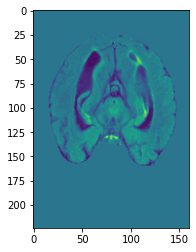

In [48]:
plt.imshow(x[30][0]);

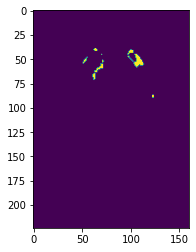

In [49]:
plt.imshow(y[30].squeeze());

In [50]:
actual_dice_mean(pred, y.to(pred.device), reduction=None)

tensor([0.2727, 0.2162, 0.3861, 0.4065, 0.3364, 0.3033, 0.3077, 0.3876, 0.1905,
        0.0800, 0.3077, 0.3333, 0.0556, 0.2178, 0.2566, 0.2583, 0.3874, 0.3065,
        0.3683, 0.3726, 0.3490, 0.3080, 0.3835, 0.3562, 0.0143, 0.0000, 0.0000,
        0.1765, 0.1289, 0.3688, 0.3815, 0.3699, 0.3289, 0.3898, 0.4022, 0.3024,
        0.1886, 0.2638, 0.3564, 0.3729, 0.3574, 0.3659, 0.3625, 0.3534, 0.3064,
        0.3693, 0.2574, 0.3345, 0.2471, 0.3721, 0.2059, 0.3333, 0.2838, 0.3333,
        0.2432, 0.2785, 0.3165, 0.2500, 0.3519, 0.2000, 0.1765, 0.0625, 0.0000,
        0.0851])

In [51]:
actual_dice_block(pred, y.to(pred.device))

tensor(0.3189)

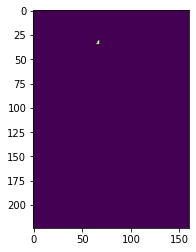

In [52]:
plt.imshow(y[1].squeeze())

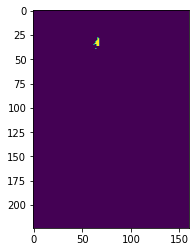

In [53]:
plt.imshow(torch.nn.functional.softmax(pred, dim=1).argmax(dim=1)[1].detach().cpu().numpy())

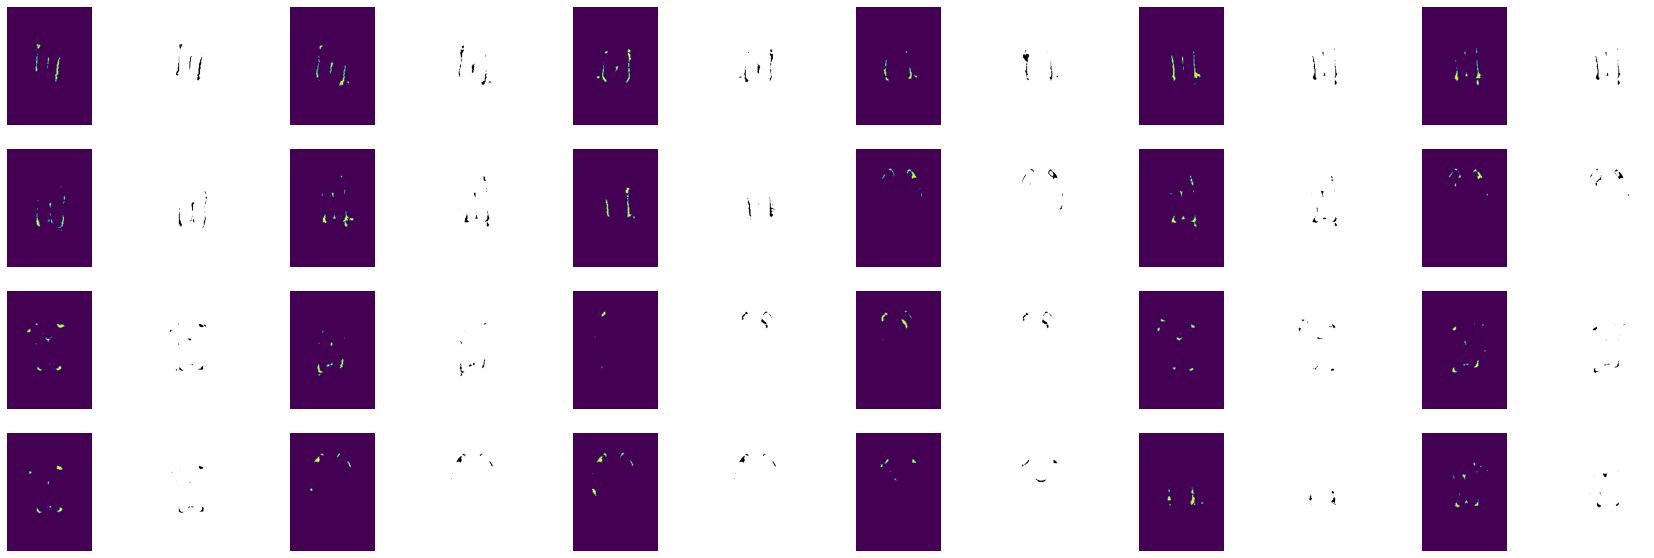

In [54]:
plt.figure(figsize=(30, 10))
count = 1
for i in range(0,24):
    plt.subplot(4, 12, count)
    plt.imshow(cs[highest[i]].detach().cpu().numpy())
    plt.axis('off')
    plt.subplot(4, 12, count+1)
    plt.imshow(y[highest[i]].numpy(), cmap='Greys')
    plt.axis('off')
    count+=2

In [55]:
#trainer.validate(model, val_dataloader, ckpt_path='best')
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.37814292311668396
    val_metric_epoch        0.36361104249954224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.36361104249954224, 'val_loss': 0.37814292311668396}]

### Loading the dataset in 3D for analysis
now each sample from the 3D dataset we can treat as a batch, and is a single image sample. Note that each batch may not be the same size now.

In [56]:
# # load datasets
# # this step is quite slow, all the data is being loaded into memory
# # BIG NOTE
# # during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# # and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
# domains = [ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]]
# # domains = [wmh_dir + d for d in ['Singapore', 'GE3T', 'Utrecht']]
# datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=LabelSelect(label_id=1)) for domain in domains]


# # split into train, val test datasets
# datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# # concat the train val test datsets
# train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
# val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
# test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

In [57]:
# NOW JUST USE THE 3D DATA DIRECT
# train_dataset_3d = splits[0]
# val_dataset_3d = splits[1]
# test_dataset_3d = splits[2]

In [58]:
train_dataset_3d[0][0].shape

torch.Size([3, 40, 224, 160])

In [59]:
y.shape

torch.Size([64, 224, 160])

In [60]:
import scipy.spatial
from tqdm import tqdm

In [66]:
with torch.no_grad():
    mcuda = model.cuda()
    dices = []
    for j in tqdm(range(len(test_dataset_3d)), position=0, leave=True):
        #j = 14
        x, y = train_dataset_3d[j]
        i = x.swapaxes(0,1)
        pred = mcuda(i.cuda())
        out = torch.nn.functional.softmax(pred, dim=1).cpu().argmax(dim=1)
        target = y.squeeze()
        # dice = actual_dice_block(pred.cpu(), target)
        # print(dice)
        dices.append(1. - scipy.spatial.distance.dice(target.view(-1), out.view(-1)))
        #break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.66it/s]


In [67]:
dices_nonzero = [d for d in dices if d > 0]
ds = torch.Tensor(dices_nonzero)
torch.mean(ds)

tensor(0.7155)

In [68]:
dices

[0.8596420555907234,
 0.6807051909892263,
 0.6901748040988547,
 0.8600572905750017,
 0.7567001675041876,
 0.5503472222222222,
 0.7114163090128756,
 0.6770265940403717,
 0.8112434419637728,
 0.8551706036745407,
 0.8786649885796858,
 0.5630667765869745,
 0.6658234252466482,
 0.0,
 0.6780721886083872,
 0.763656980864635,
 0.5203316225819187,
 0.7599525962340341,
 0.8481826305018303,
 0.6995633187772925,
 0.6336633663366337,
 0.6700632466619818,
 0.7677403120281832,
 0.5563561502830674]

In [202]:
dices_nonzero = [d for d in dices if d > 0]
ds = torch.Tensor(dices_nonzero)
torch.mean(ds)

tensor(0.7121)

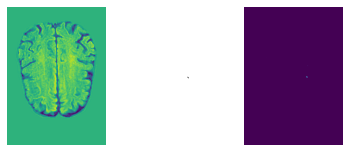

In [121]:
plt.subplot(1,3,1)
islice = 29
plt.imshow(i[islice][0]); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(target[islice], cmap='Greys'); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(out[islice][1]); plt.axis('off');

### generating the samples procedure, only do this once

In [88]:
from tqdm import tqdm

In [89]:
xs3d = []
ys3d = []
for x, y in val_dataset_3d:
    xs3d.append(x)
    ys3d.append(y)

In [90]:
root = "/home/s2208943/ipdis/results/final_models/"
#folders = ["ensemble" + ndigit(2, x+1) + "/" for x in range(20)]

In [91]:
rootdir = "/disk/scratch/s2208943/results/final_models/"
f = "ssn_hpt10/"
ckpts = sorted([c for c in os.listdir(root+f) if "epoch" in c])
c = ckpts[-1]
# model = StandardLitModelWrapper.load_from_checkpoint(root + f + c, model=model_raw, loss=loss, 
#                                 logging_metric=SsnDiceMetricWrapper,
#                                )

In [92]:
def gen_samples(xs3dQ, ys3dQ, model=model):
    samples3d = []
    model = model.cuda()
    for i in tqdm(range(len(ys3dQ)), position=0, leave=True, ncols=150):

        with torch.no_grad():
            out = model(xs3dQ[i].swapaxes(0,1).cuda())
            samples = fixed_re_parametrization_trick(out['distribution'], 20).cpu()
            samples3d.append(samples)
            
    return samples3d

In [93]:
samples3d = gen_samples(xs3d, ys3d)

 59%|██████████████████████████████████████████████████████████████████▉                                              | 29/49 [00:10<00:09,  2.17it/s]

was thrown:  torch.linalg_cholesky: (Batch element 8): The factorization could not be completed because the input is not positive-definite (the leading minor of order 9 is not positive-definite).
hmm: Covariance became non invertible using independent normals for this batch!
cov diag okay:  tensor(0, device='cuda:0')
sqrt cov diag okay:  tensor(0, device='cuda:0')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:40<00:00,  1.22it/s]


In [94]:
means3d = [torch.mean(samples3d[i], dim=0) for i in range(len(samples3d))]

In [95]:
samples3d[0].shape, means3d[0].shape

(torch.Size([20, 40, 2, 224, 160]), torch.Size([40, 2, 224, 160]))

In [96]:
len(samples3d)

49

In [97]:
len(samples3d), len(samples3d[0])

(49, 20)

### generating the 2D samples of the first batch only, for the pictures! (and compute computation time)

In [98]:
import timeit

In [99]:
xs = []
ys = []
for x, y in val_dataloader:
    xs.append(x)
    ys.append(y)
    break

In [100]:
samples2d_onebatch = []
model = model.cuda()
start_time = timeit.default_timer()


with torch.no_grad():
    out = model(xs[0].cuda())
    samples = fixed_re_parametrization_trick(out['distribution'], 20).cpu()
    samples2d_onebatch = samples
        
elapsed = timeit.default_timer() - start_time

In [101]:
samples2d = samples2d_onebatch

In [102]:
print("elapsed time (s): ", elapsed)

elapsed time (s):  0.539143854752183


In [103]:
len(samples2d_onebatch)

20

### fixed compute section

In [104]:
model_name = "ssn"

In [105]:
#os.mkdir("results/" + model_name)

### Generating uncertainty maps for a batch


In [106]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

### Creating the entropy map for the 2D samples

In [107]:
samples2d.shape

torch.Size([20, 64, 2, 224, 160])

In [108]:
ent2dbatch = entropy_map_from_samples(samples2d)

In [109]:
ent2dbatch.shape

torch.Size([64, 224, 160])

In [110]:
def save(fname):
    plt.tight_layout()
    plt.savefig("results/"+model_name + "/" + fname, bbox_inches = "tight")


In [111]:
showpred = samples2d.mean(dim=0).argmax(dim=1)

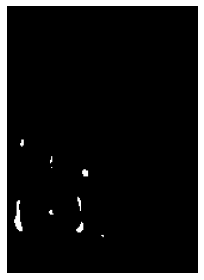

In [112]:
plt.imshow(showpred[5], cmap='gray');
plt.axis('off');
save("pred5")

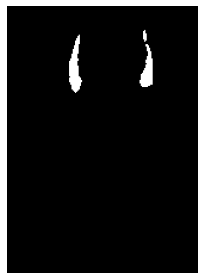

In [113]:
plt.imshow(showpred[20], cmap='gray');
plt.axis('off');
save("pred20")

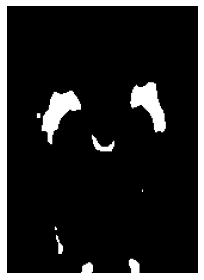

In [114]:
plt.imshow(showpred[58], cmap='gray');
plt.axis('off');
save("pred58")

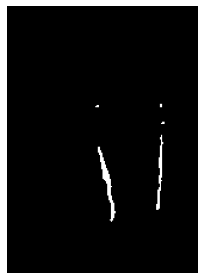

In [115]:
plt.imshow(showpred[37], cmap='gray');
plt.axis('off');
save("pred37")

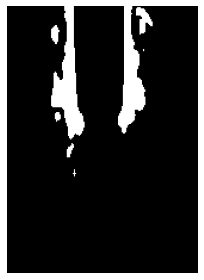

In [116]:
plt.imshow(showpred[62], cmap='gray');
plt.axis('off');
save("pred62")

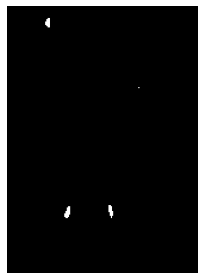

In [117]:
plt.imshow(showpred[49], cmap='gray');
plt.axis('off');
save("pred49")

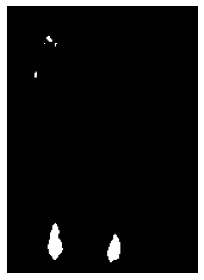

In [118]:
plt.imshow(showpred[50], cmap='gray');
plt.axis('off');
save("pred50")

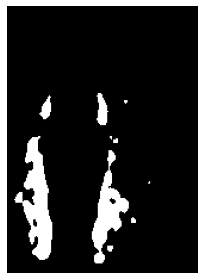

In [119]:
plt.imshow(showpred[23], cmap='gray');
plt.axis('off');
save("pred23")

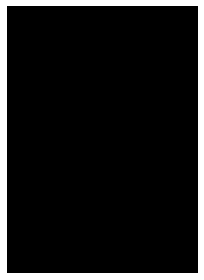

In [120]:
plt.imshow(showpred[30], cmap='gray');
plt.axis('off');
save("pred30")

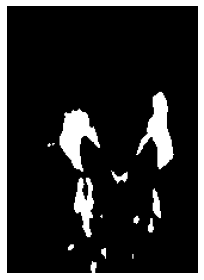

In [121]:
plt.imshow(showpred[48], cmap='gray');
plt.axis('off');
save("pred48")

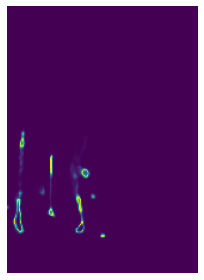

In [122]:
plt.imshow(ent2dbatch[5], vmin=0, vmax=0.7);
plt.axis('off');
save("img5")

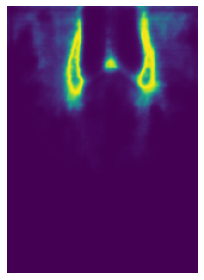

In [123]:
plt.imshow(ent2dbatch[20], vmin=0, vmax=0.7);
plt.axis('off');
save("img20")

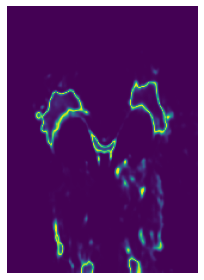

In [124]:
plt.imshow(ent2dbatch[58], vmin=0, vmax=0.7);
plt.axis('off');
save("img58")

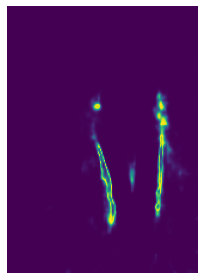

In [125]:
plt.imshow(ent2dbatch[37], vmin=0, vmax=0.7);
plt.axis('off');
save("img37")

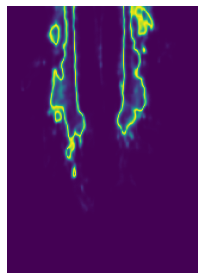

In [126]:
plt.imshow(ent2dbatch[62], vmin=0, vmax=0.7);
plt.axis('off');
save("img62")

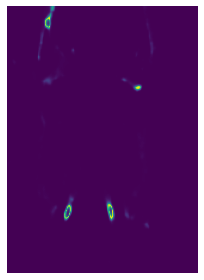

In [127]:
plt.imshow(ent2dbatch[49], vmin=0, vmax=0.7);
plt.axis('off');
save("img49")

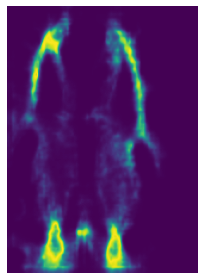

In [128]:
plt.imshow(ent2dbatch[50], vmin=0, vmax=0.7);
plt.axis('off');
save("img50")

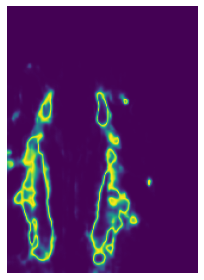

In [129]:
plt.imshow(ent2dbatch[23], vmin=0, vmax=0.7);
plt.axis('off');
save("img23")

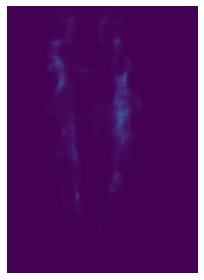

In [130]:
plt.imshow(ent2dbatch[30], vmin=0, vmax=0.7);
plt.axis('off');
save("img30")

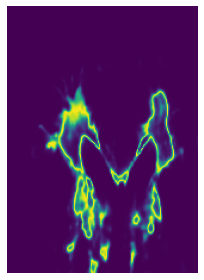

In [131]:
plt.imshow(ent2dbatch[48], vmin=0, vmax=0.7);
plt.axis('off');
save("img48")

In [132]:
# plt.figure(figsize=(30,20))
# ids = 5, 20, 58, 37, 62, 49, 50, 23, 30, 48
# count = 0
# for i in range(64):
#     if torch.sum(ys[0][i]) > 0:
#         plt.subplot(6, 12, count+1)
#         plt.imshow(ys[0][i], cmap='gray')
#         plt.title(i)
#         plt.axis('off')
#         plt.subplot(6, 12, count+2)
#         plt.imshow(ent2dbatch[i], vmin=0, vmax=0.7)
#         plt.title(i)
#         plt.axis('off')
#         count += 2

interesting images: 5, 20, 58, 37, 62, 49, 50, 23, 30, 48

### How do average dice and best dice improve with samples

In [133]:
len(samples3d), len(samples3d[0]), len(ys3d)

(49, 20, 49)

In [134]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    #print(y_pred.shape, y_true.shape)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [135]:
# compute the dice per sample, per individual
dices3d = []
for ind in tqdm(range(len(samples3d)), position=0, leave=True, ncols=150):
    sample_dices = []
    for s in range(len(samples3d[ind])):
        y_hat = samples3d[ind][s]
        y = ys3d[ind]
        sample_dices.append(dice(y_hat, y))
    dices3d.append(sample_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:59<00:00,  4.89s/it]


In [136]:
tensor_alldice3d = torch.stack([torch.Tensor(ds) for ds in dices3d], dim=0).swapaxes(0,1)

In [137]:
tensor_alldice3d.shape

torch.Size([20, 49])

In [138]:
# compute the mean and best dice as the number of samples increases from 1 to 20:
samples_vs_dices_mean = []
samples_vs_dices_best = []
for i in range(20):
    selected_samples_dices = tensor_alldice3d[0:i+1]
    mean_dice = torch.mean(selected_samples_dices, dim=0)
    best_dice = torch.max(selected_samples_dices, dim=0)[0]
    
    samples_vs_dices_mean.append(mean_dice.mean())
    samples_vs_dices_best.append(best_dice.mean())

In [139]:
mean_dice.mean(),mean_dice.std(), best_dice.mean(), best_dice.std()

(tensor(0.6514), tensor(0.1419), tensor(0.6762), tensor(0.1329))

In [140]:
samples_vs_dices_mean[0].shape

torch.Size([])

In [141]:
plt.style.use('fivethirtyeight')

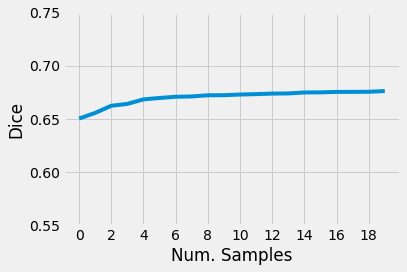

In [142]:
plt.plot(torch.arange(0, len(samples_vs_dices_mean), 1), samples_vs_dices_best)
plt.ylim(0.55, 0.75)
plt.xticks(torch.arange(0, 20, 2));
plt.xlabel("Num. Samples")
plt.ylabel("Dice");
save("samples_v_dice")

In [143]:
#print(torch.Tensor(samples_vs_dices_best))

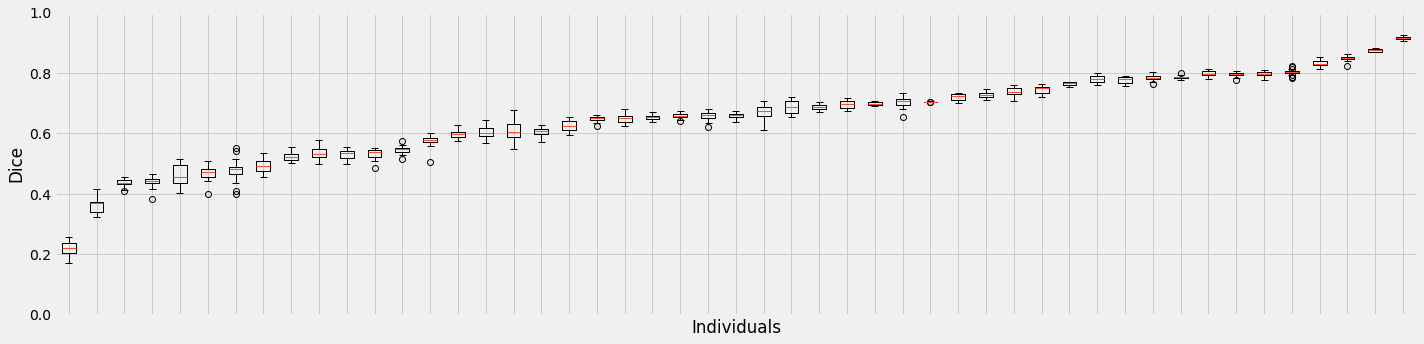

In [144]:
# sort in order of quality
order = torch.sort(torch.median(tensor_alldice3d, dim=0)[0])[1]
plt.figure(figsize=(20, 5))
plt.boxplot(tensor_alldice3d.T[order]);
plt.ylim(0, 1);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Dice")
plt.xlabel("Individuals")
save("sample_diversity")

### Calibration

In [145]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [146]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [147]:
len(samples3d)

49

In [148]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx]
    batch_samples = samples3d[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:22<00:00,  2.90s/it]


In [149]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [150]:
bin_accuracies

[0.0007935936446301639,
 0.12762148678302765,
 0.20524169504642487,
 0.2653273940086365,
 0.3201628625392914,
 0.3763694167137146,
 0.4365476071834564,
 0.5060350894927979,
 0.5935199856758118,
 0.7275901436805725,
 0.9228336811065674]

In [151]:
bin_confidences

[0.00023139645054470748,
 0.08925336599349976,
 0.19552698731422424,
 0.29749080538749695,
 0.398568332195282,
 0.4993383586406708,
 0.6001362204551697,
 0.7011681795120239,
 0.8028141856193542,
 0.907695472240448,
 0.9864658117294312]

In [152]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0847)


In [153]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

'\nlooking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing\nand when optimizing calibration I should be optimizing this.\n'

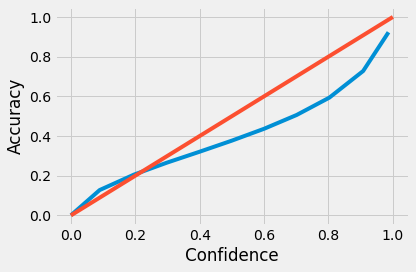

In [154]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
save("calibration")

In [155]:
#exd = batch_t.expand(p1s.shape)

In [156]:
# plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
# plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [157]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx]
    batch_samples = samples3d[batch_idx]
    ent = entropy_map_from_samples(batch_samples)
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [04:38<00:00,  5.68s/it]


In [158]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [159]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

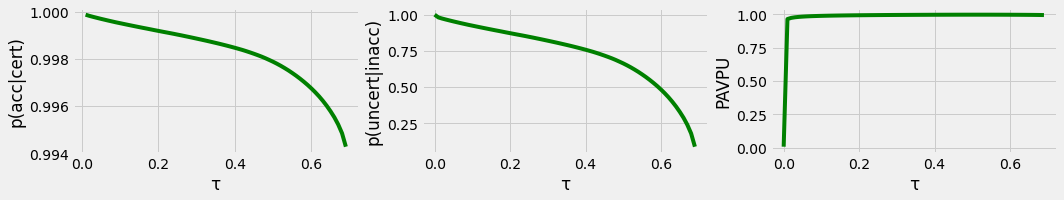

In [160]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs, c='g')
plt.xlabel("τ")
plt.ylabel("p(acc|cert)")
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus, c='g')
plt.ylabel("p(uncert|inacc)")
plt.xlabel("τ")
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu, c='g')
plt.ylabel("PAVPU")
plt.xlabel("τ")
save("pavpu")


In [161]:
#uncetainty_thresholds

In [162]:
i=5
uncetainty_thresholds[i], p_acs[i], p_aus[i], pavpu[i]

(tensor(0.0500), tensor(0.9997), tensor(0.9534), tensor(0.9826))

In [163]:
#ent_thresh = uncetainty_thresholds[i]

In [164]:
ent_thresh = 0.05

### Quality Control in 3D - vcc corr-coeff

In [165]:
# generate entropy maps per individual
ind_ent_maps = [entropy_map_from_samples(samples3d[i]) for i in range(len(ys3d))]

In [166]:
def VVC(v):
    v = torch.nn.functional.softmax(v, dim=2)
    return torch.std(v) / torch.mean(v)

In [167]:
vvcs = [VVC(samples3d[i]) for i in range(len(ys3d))]

In [168]:
#vvcs_ent = [VVC(ind_ent_maps[i]) for i in range(len(ys3d))]

In [169]:
medians = torch.median(tensor_alldice3d, dim=0)[0]

In [170]:
print("correlation coefficient: ", torch.corrcoef(torch.stack([torch.Tensor(vvcs), medians]))[0][1])

correlation coefficient:  tensor(-0.6407)


In [171]:
#plt.scatter(vvcs, medians)

### TP FP TN FN distribution

In [172]:
all_tps = []
#all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for i in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
        samples = samples3d[i]
        mean = means3d[i]
        ent = ind_ent_maps[i].view(-1)
        mean_class = mean.argmax(dim=1).view(-1)
        y = ys3d[i]
        x = xs3d[i].swapaxes(0,1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        #tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        #all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:12<00:00,  3.95it/s]


In [173]:
tps = torch.cat(all_tps)
#tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [174]:
tps.shape, fps.shape, fns.shape

(torch.Size([551090]), torch.Size([151774]), torch.Size([176756]))

In [175]:
tps.mean(), fps.mean(), fns.mean()

(tensor(0.2331), tensor(0.5004), tensor(0.3799))

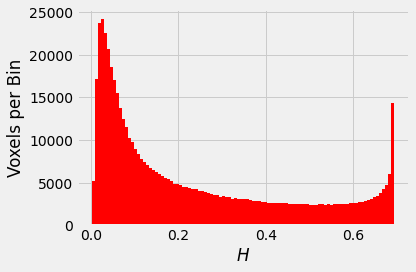

In [176]:
plt.hist(tps, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 350000))
plt.xlabel("$H$")
save("tps")

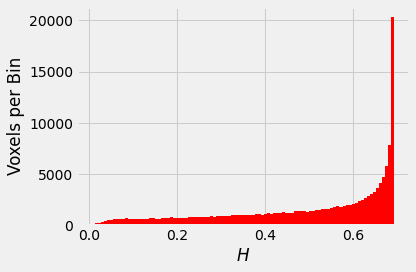

In [177]:
plt.hist(fps, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 50000))
plt.xlabel("$H$")
save("fps")

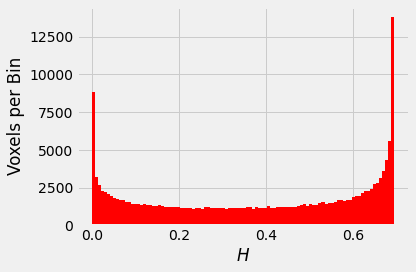

In [178]:
plt.hist(fns, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 155000))
plt.xlabel("$H$")
save("fns")

In [179]:
import seaborn as sns

In [180]:
j = -1
ntps = len(tps)
nfns = len(fns)
nfps = len(fps)
data = {"label":["TP" for _ in range(ntps)][0:j] + ["FN" for _ in range(nfns)][0:j] + ["FP" for _ in range(nfps)][0:j], "ent": torch.cat([tps[0:j], fns[0:j], fps[0:j]]).numpy()}

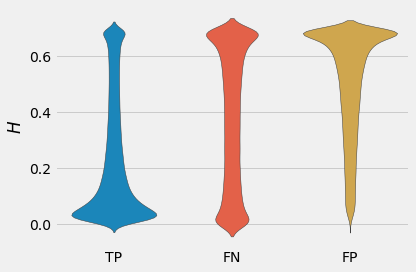

In [181]:
#plt.figure(figsize=(20, 5))
sns.violinplot(x="label", y="ent", data=data, linewidth=0.5, inner=None)
plt.ylabel("$H$")
save("types_violin")

### Missing lesions in 2D slices

In [182]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [183]:
conncomp_outs = []

for y in tqdm(ys3d, position=0, leave=True, ncols=150):
    labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
    conncomp_outs.append(labels_out)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:30<00:00,  1.84s/it]


In [184]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
proportion_missing_lesion_covered_ent = []
missing_lesion_size_mean = []
for batch in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
    for i in range(0, ys3d[batch].shape[0], 3):
        conncomps = conncomp_outs[batch][i]
        ent = ind_ent_maps[batch][i]
        uncert = (ent > ent_thresh).type(torch.long)
        mean = means3d[batch].argmax(dim=1)[i]
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(uncert * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)
                
            if torch.max(mean * cc) > 0:
                proportion_missing_lesion_covered_ent.append(torch.sum(uncert * cc) / size)
                missing_lesion_size_mean.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:21<00:00,  4.11s/it]


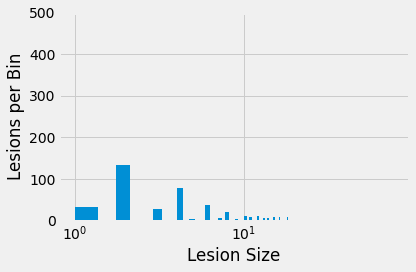

In [185]:
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.ylim(0, 500)
plt.xlabel("Lesion Size")
plt.ylabel("Lesions per Bin")
save("missing_lesions")

In [186]:
print("means and stds of existing and missing lesions in 2D")
existing = torch.Tensor(existing_lesion_size_ent)
missing = torch.Tensor(missing_lesion_size_ent)
existing.mean(), existing.std(), missing.mean(), missing.std()

means and stds of existing and missing lesions in 2D


(tensor(85.4047), tensor(288.7009), tensor(6.4147), tensor(8.1529))

In [187]:
print("total number of lesions missing in 2D", len(missing_lesion_size_ent))

total number of lesions missing in 2D 434


In [188]:
print("mean proportion of missing lesion covered by uncertainty: ", torch.Tensor(proportion_missing_lesion_covered_ent).mean())

mean proportion of missing lesion covered by uncertainty:  tensor(0.9083)


### How do uncertainty maps differ depending on the WMH damage values?

In [189]:
true_wmh_damage = []
lhss = []
rhss = []

for i in range(len(ys3d)):
    x = xs3d[i]
    y = ys3d[i]

    min_intensity = torch.min(x[0])
    norm_max_intensity = torch.max(x[0][y == 1]) - min_intensity
    nawm_range = (norm_max_intensity*0.5 + min_intensity, norm_max_intensity*0.75 + min_intensity)
    wmh_voxels = x[0][y==1]
    nawm_voxels = x[0][torch.logical_and(torch.logical_and(torch.logical_and(y==0, x[1] == 1), x[0] > nawm_range[0]), x[0] < nawm_range[1])]

    I_wmh = torch.mean(wmh_voxels)
    I_nawm = torch.mean(nawm_voxels)

    wmh_volume = wmh_voxels.shape[0]
    nawm_volume = nawm_voxels.shape[0]

    lhs = ((I_wmh - I_nawm) / I_nawm)
    rhs = (wmh_volume / (wmh_volume + nawm_volume))
    damage = lhs * rhs

    true_wmh_damage.append(damage)
    lhss.append(lhs)
    rhss.append(rhs)

    print("I_wmh: ", I_wmh, "I_nawm: ", I_nawm, "wmh volume: ", wmh_volume, "normal volume: ", nawm_volume, lhs, rhs, damage)


I_wmh:  tensor(1.4955) I_nawm:  tensor(0.7728) wmh volume:  4300 normal volume:  330284 tensor(0.9351) 0.01285178012098606 tensor(0.0120)
I_wmh:  tensor(1.5266) I_nawm:  tensor(0.8677) wmh volume:  7943 normal volume:  287097 tensor(0.7593) 0.02692177331887202 tensor(0.0204)
I_wmh:  tensor(1.4383) I_nawm:  tensor(0.7223) wmh volume:  5008 normal volume:  375239 tensor(0.9914) 0.013170386617119926 tensor(0.0131)
I_wmh:  tensor(1.6008) I_nawm:  tensor(0.6402) wmh volume:  5201 normal volume:  364380 tensor(1.5004) 0.014072693130869823 tensor(0.0211)
I_wmh:  tensor(1.9235) I_nawm:  tensor(0.8225) wmh volume:  22216 normal volume:  375331 tensor(1.3386) 0.05588270066180854 tensor(0.0748)
I_wmh:  tensor(1.6343) I_nawm:  tensor(0.8262) wmh volume:  6784 normal volume:  319174 tensor(0.9780) 0.02081249731560508 tensor(0.0204)
I_wmh:  tensor(1.3988) I_nawm:  tensor(0.6324) wmh volume:  4115 normal volume:  438407 tensor(1.2119) 0.009298972706441713 tensor(0.0113)
I_wmh:  tensor(1.7206) I_nawm:

In [190]:
mean3ddice = tensor_alldice3d.mean(dim=0)

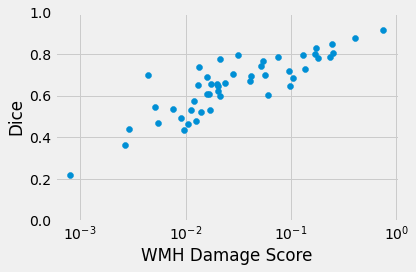

In [191]:
plt.scatter(true_wmh_damage, mean3ddice)
plt.xscale('log')
plt.ylim(0, 1)
plt.ylabel('Dice')
plt.xlabel('WMH Damage Score')
save("dice_v_damage")

In [192]:
ind_ent_sums = [torch.sum(e) for e in ind_ent_maps]

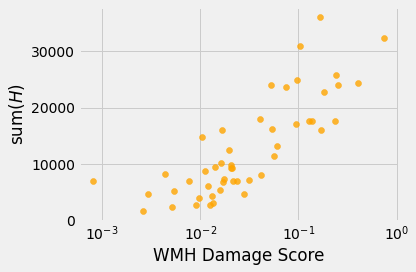

In [193]:
plt.scatter(true_wmh_damage, ind_ent_sums, alpha=0.8, c='orange')
plt.xscale('log')
plt.ylabel('sum($H$)')
plt.xlabel('WMH Damage Score')
save("ent_v_damage")

In [194]:
print("correlation coefficient: ", torch.corrcoef(torch.stack([torch.Tensor(ind_ent_sums), torch.log10(torch.Tensor(true_wmh_damage))]))[0][1])

correlation coefficient:  tensor(0.8074)


### Domain Adaption

In [195]:
domains_all = [wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

In [ ]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
datasets_domains_all = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains_all]


In [ ]:
# assess bin counts of p y = 1
def ECE_domains(qys3d, qsamples3d):
    bins = 10 + 1 # for the 0 bin
    bin_batch_accuracies = [[] for b in range(bins)]
    bin_batch_confidences = [[] for b in range(bins)]
    bin_batch_sizes = [[] for b in range(bins)]
    bin_counts = [0 for b in range(bins)]
    for batch_idx in tqdm(range(0, len(qys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        batch_t = qys3d[batch_idx]
        batch_samples = qsamples3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        probs = torch.nn.functional.softmax(batch_samples, dim=2)
        p1s = probs[:,:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            if num_elem == 0:
                print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem

            if torch.isnan(c1_acc):
                print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            if torch.isnan(c1_conf):
                print("conf_nan")

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)

    bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
    bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
    bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]
    total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
    ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
    print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

In [ ]:
# compute the dice per sample, per individual
def dices_ind(qsamples, qys):
    qdices3d = []
    for ind in tqdm(range(0, len(qsamples)), position=0, leave=True, ncols=150):
        sample_dices = []
        for s in range(len(qsamples[ind])):
            y_hat = qsamples[ind][s]
            y = qys[ind]
            sample_dices.append(dice(y_hat, y))
        qdices3d.append(sample_dices)
        
    qtensor_alldice3d = torch.stack([torch.Tensor(ds) for ds in qdices3d], dim=0).swapaxes(0,1)
    qmean_dice = torch.mean(qtensor_alldice3d, dim=0)
    qbest_dice = torch.max(qtensor_alldice3d, dim=0)[0]
    
    return qmean_dice.mean(), qmean_dice.std(), qbest_dice.mean(), qbest_dice.std()




### domain 1

In [ ]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[0]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [ ]:
wsamples3d = gen_samples(wxs3d, wys3d)

In [ ]:
ECE_domains(wys3d, wsamples3d)

In [ ]:
dices_ind(wsamples3d, wys3d)

### doamain 2

In [ ]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[1]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [ ]:
wsamples3d = gen_samples(wxs3d, wys3d)

In [ ]:
ECE_domains(wys3d, wsamples3d)

In [ ]:
dices_ind(wsamples3d, wys3d)

### domain 3

In [ ]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[2]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [ ]:
wsamples3d = gen_samples(wxs3d, wys3d)

In [ ]:
ECE_domains(wys3d, wsamples3d)

In [ ]:
dices_ind(wsamples3d, wys3d)